# Plant Performance Analysis - 2020
#### This analysis is confidential.
By: James Flannery

![Combine Cycle Power Plant](img/ccpp.gif)

The Power Plant is a 575 MW (with duct burners) 2×1 GE 7FA combined-cycle gas turbine power plant with an Alstom steam turbine. The plant can also burn ultra-low sulfur No.2 fuel oil.

## Introduction

This project was carried out to determine an easier way to visualize the plant perfomance data.

Plant operators suspected that one of the gas turbines was not operating at the expected efficiency (heat rate) above a certain generator load. The plant manager requested the control analyze the logs to confirm.

## Environment & Libraries



## Data Source

The data was imported from an excel file. This excel file imports data from the plant PI server (OSIsoft) is used by plant management to monitor plant operation and financial performance. The PI server reflects the raw values 

![PI Server](img/PIServer.jpeg)

## Data Import & Processing
The data is organized into tables consisting of one row per day, and each columns refelcting the value at each hour on the hour. The initial dataframe created has an index of each day of the year in a datetime format.

Due to the formatting of the excel file, custom functions were required to loop through the tables and import data into each column of the [pandas](https://pandas.pydata.org/) dataframe. The python library [Openpyxl](https://openpyxl.readthedocs.io/en/stable/) is used to get the value of cells and custom ranges.

In [1]:
import openpyxl
import pandas as pd
from datetime import datetime, date, time
import numpy as np

In [2]:
#Open Document and Sheet
doc = openpyxl.load_workbook('data/heatrate.xlsx')
sheet = doc['Sheet1']

In [3]:
#Create list of hrs in a year. 
all_hrs = []
#Get the date from first column in the row. Ouput value is type datetime.
#To keep the data to a reasonable size, (rows 68 through 129 are selected). 
for i in range(68,129,1):
    date = sheet.cell(row=i,column=1).value
    #Get value of each hr of the day. All values are time, execpt 0:00hrs which is datetime.
    for j in range(2, 26, 1):
        t = sheet.cell(row=7,column=j).value
        #This is overkill.... use if/else to determine datatype, then get value as time.
        #combine function needs a (datetime, time) input data types. Tedious.
        if(type(t) is datetime):
            t = datetime.time(t)
            dt = datetime.combine(date, t)
            all_hrs.append(dt)
        elif(type(t) is time):
            dt = datetime.combine(date, t)
            all_hrs.append(dt)

#Check number of days for accuracy
#print(len(all_hrs)) # Checked
#Check first 2 days of year for accuracy
#print(all_hrs[:48]) #Checked
#Check last 2 days of year for accuracy
#print(all_hrs[-48:]) #Checked

In [4]:
#Create pandas dataframe from list. Datetimes to be used as index
df = pd.DataFrame(all_hrs)

In [5]:
#Define function that takes a range of cells, and outputs a tuple of cell values.
def RangeValue(a, b, c, d):
    '''a = row start
       b = row end
       c = column start
       d = column end'''
    return(tuple(tuple(sheet.cell(row=a+i, column=c+j).value for j in range(d-c+1)) for i in range(b-a+1)))

In [6]:
#Function takes column range values so that it can be iterated, and creates a column in pandas dataframe.
def table_to_df(c,d):
    #Create tuple "cell_range", taking the start and stop columns.
    #Row values are the row 68 through 128 for all tables.
    cell_range = RangeValue(68,128,c,d)
    
    list = []
    for i,j in enumerate(cell_range):
        for x in j:
            list.append(x)
    '''       
    value_list = []
    for i in list:
        value_list.append(i)
    '''    
    #Get cell value of title box. Pass through string function.
    name = ''
    for cell in range(c,c+23):
        #Column name is found in start column ('c') on row 5.
        value = sheet.cell(row=5, column=cell).value
        if type(value) is str:
            name += ' ' +value
    
    name = name.lstrip()
    name = name.rstrip()
    #Create column in dataframe
    df[name] = list

In [7]:
#This is the incredibly boring and tedious. Since there is no cleaer pattern in the column number,
#column numbers are put into a list, so that ranges can be created. Row values are constant.

list  = [25, 51, 77, 103, 129, 155, 181, 207, 233, 259, 285, 311, 311, 363, 389, 415, 441, 467, 493, 519, 545, 571, 597, 
         623, 649, 675, 701,727,753,779,805,831,857,883,909,935,961,990,1016,1045,1071,1097,1123,1149,1175]

#Iterate through the column number list and call function to add each table to the dataframe
for i in list:
    j = i - 23
    table_to_df(j,i)

In [8]:
#Rename time column to 'date_time'
df = df.rename({0 : 'date_time'}, axis='columns')

In [9]:
#Define Function to take Dataframe column and convert all values to float or NaN.
def float_to_Nan(x):
    'Input is DataFrame column'
    try:
        return np.float(x)
    except:
        return np.nan

In [10]:
#Skip date_time column
for column in df:
    if column is 'date_time':
        pass
    else:
        df[column] = df[column].apply(float_to_Nan)

In [11]:
#Set 'date_time' as dataframe index
df['dt_index'] = pd.to_datetime(df['date_time'])
df = df.set_index('dt_index')
df.drop(['date_time'], axis = 1, inplace = True);

In [12]:
#There should be no negative values coming from these sensors.
df[df<0]=0

## Interactive Visualization for Plant Performance Analysis

The Astoria power plant has a few different operating conditions that we need to take into account. The conditions we analyze are each GT operating on its own. We will create a new dataframe for each turbine and remove data from when the turbine was not in operation.

In [13]:
import matplotlib.pyplot as plt
import plotly
import cufflinks as cf
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objects as go
import chart_studio
import chart_studio.plotly as py

chart_studio.tools.set_credentials_file(username='jimflann', api_key='mO6ThElZzBSIESySEW6K')

In [14]:
#Create new dataframe by passing name of new dataframe and column name from 'df'.
def fplotly(df, x):
    df_name = pd.DataFrame()
    df_name[x] = df[x]
    b = df_name[x]
    values = go.Scatter(x=b.index, y=b.values, name = x)
    layout = go.Layout(title='Plant Analysis' + ' - ' + x, xaxis=dict(title='Date'),yaxis=dict(title='Units'))
    fig = go.Figure(data=[values], layout = layout)
    return py.iplot(fig, sharing='public')

In [15]:
fplotly(df, 'HIGHER HEATING VALUE')

In [16]:
# Heat Rate for total power plant based on client gas meter.
df['GT_GROSS_OUTPUT'] = df['CT 101 CT1 GROSS MW OUTPUT'] + df['CT 201 CT2 GROSS MW OUTPUT']
df['Heatrate'] = (df['CONED METER GAS FLOW IN KSCFH'] * df['HIGHER HEATING VALUE']) / df['GT_GROSS_OUTPUT']

In [17]:
fplotly(df, 'Heatrate')

When plotting the calculated heat rate, there is a large positive values on March 30th. This is due to CT201's sensor reading a a negative ouput. This could be because the unit reverse power relay was delayed during a trip, or an error sensor.

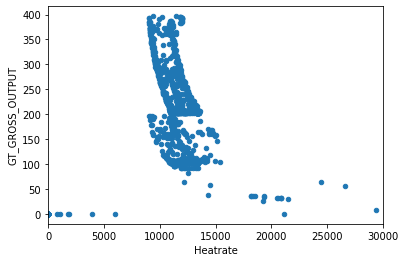

In [18]:
df.plot.scatter(x = 'Heatrate',
                y = 'GT_GROSS_OUTPUT',
                xlim = (0,30000))

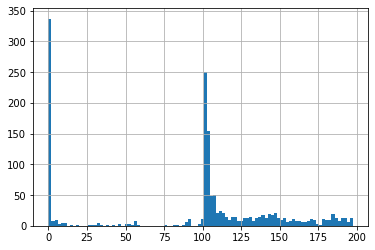

In [19]:
df['CT 201 CT2 GROSS MW OUTPUT'].hist(bins=100)

The above chart shows that CT102 idles ~100MW. Any values near 0 the unit can be considered offline. And the smaller values in between mean the unit was starting or stopping when at the top of the hour.

In [20]:
#Heat Rate for CT101 in 1x1 Operation (1 unit in operation)

CT201_offline = df['CT 201 CT2 GROSS MW OUTPUT'] < 75
CT101 = df[CT201_offline]
CT101['CT101_Heatrate'] = (CT101['CT 101 GAS FLOW KSCFH'] * CT101['HIGHER HEATING VALUE']) / (CT101['CT 101 CT1 GROSS MW OUTPUT'])

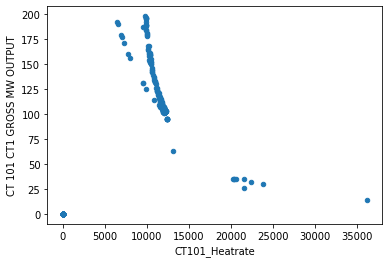

In [21]:
CT101.plot.scatter(x = 'CT101_Heatrate',
                   y = 'CT 101 CT1 GROSS MW OUTPUT')

It is clear in the plot above, that there have been two operational profiles for this gas turbine. Case Closed?